In [1]:
import pydci.SequentialDensityProblem as SDP
from pydci import plotting as plt
import importlib

importlib.reload(SDP)
SDP.enable_log()

[04/03/23 15:14:32] INFO     Logger initialized                                      ]8;id=164846;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/SequentialDensityProblem.py\SequentialDensityProblem.py]8;;\:]8;id=317255;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/SequentialDensityProblem.py#51\51]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

# <center> Sequential MUD estimation for ODE Systems </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

# Lotka-Volterra

## Mud Estimation example for Predator Prey model

- Model: 
$$
\begin{aligned}
& \frac{d x}{d t}=\alpha x-\beta x y \\
& \frac{d y}{d t}=\delta x y-\gamma y
\end{aligned}
$$
where
- $x$ is the number of prey (for example, rabbits);
- $y$ is the number of some predator (for example, foxes);
- $\frac{d y}{d t}$ and $\frac{d x}{d t}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha, \beta, \gamma, \delta$ are positive real parameters describing the interaction of the two species:

    - $\alpha=$ growth rate of prey
    - $\beta$ = death rate of rabbits due to predatation from predators
    - $\gamma=$ natural death rate of predators
    - $\delta=$ factor describing how many consumed prey create a new predator

In [80]:
import numpy as np
from scipy.integrate import odeint

def lotka_volterra_system(
    states: list[float],
    time: np.array,
    *parameters: tuple[float, float, float, float],
) -> np.ndarray:
    """
    Parameters
    ----------
    states : list[float]
        A list of the current states of the system.
        states[0] - prey, states[1] - predator

    time : np.ndarray
        simulation time array
    *parameters : tuple[float, float, float, float]
        The parameters of the model: alpha, beta, delta, gamma
        alpha: growth rate of prey population
        beta: death rate of prey population
        delta: growth rate of predator population
        gamma: death rate of predator population

    Returns
    -------
    np.ndarray
        The derivatives of the states with respect to time.
    """
    alpha, beta, gamma, delta = parameters

    xdot = np.array(
        [
            states[0] * (alpha - beta * states[1]),
            states[1] * (-gamma + states[0] * delta),
        ]
    )
    return xdot


def run_lv(x0, times, parameter_samples) -> None:
    """
    Runs the RLC model for a specified number of drift windows.
    Uses the initial state, the drift windows, the times, the get_parameters and save_output methods of the class
    to integrate the system of ODEs and save the output for each window.

    Parameters
    ----------
    self : object
        The instance of the class
    """
    return odeint(lotka_volterra_system, x0, times, args=parameter_samples)

# Baseline
lv_p1 = [
    1.1,  # alpha - prey growth rate
    0.4,  # beta - prey death rate
    0.5,  # gamma - predator death rate
    0.1,  # delta - predator growth rate
]

# Increase in death rate of prey
lv_p2 = [
    1.1,  # alpha - prey growth rate
    0.55,  # beta - prey death rate
    0.5,  # gamma - predator death rate
    0.1,  # delta - predator growth rate
]

### CASE: 1-Parameter No-Drift

#### <center> Select Seed & Run Model <center>

In [81]:
#     Seeds
# initial Measure Outcomes
#------------------------
# (4431, 1394)      pretty good
# (629449, 281824)  good
# (590903, 655235)  pretty good
# (997469, 279770)  okay (bad E(r) to good estimate match)
# (581506, 895913)  best

# lv1_initial_seed = np.random.randint(0, 10e5)
# lv1_measurement_seed = np.random.randint(0, 10e5)

lv1_initial_seed = None # 581506
lv1_measurement_seed =  None # 95913

In [82]:
num_samples = 1000
lv1_param_mins = [0, 0, 0, 0]
lv1_true_param = lv_p1
x0 = np.array([2, 4])
param_shifts = None  # {17: lv_p2}

search_params = {
    "nc": 2,
    "method": "all",
    "best": "closest",
    "reweight": True,
    "resample": True,
    "min_weight_thresh": 1e-20,
}

lvm = SDP.SequentialDensityProblem(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.3,
    solve_ts=0.1,
    sample_ts=1,
    diff=0.5,
    hot_starts=True,
    param_mins=lv1_param_mins,
    param_shifts=param_shifts,
    search_params=search_params,
)

lvm.seq_solve(
    list(np.arange(5, 30, 5)), num_samples=num_samples, init_seed=lv1_initial_seed
)

# Results

In [69]:
lvm.get_full_df('state')

,ts,iteration,shift_idx,sample_flag,true_param_0,true_param_1,true_param_2,true_param_3,true_vals_0,true_vals_1,...,random_408_0,random_408_1,random_172_0,random_172_1,random_380_0,random_380_1,random_798_0,random_798_1,random_976_0,random_976_1
0,0.000000,0,0,True,1.1,0.4,0.5,0.1,2.000000,4.000000,...,2.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000,4.000000,2.000000,4.000000
1,0.102041,0,0,False,1.1,0.4,0.5,0.1,1.905276,3.877485,...,1.793152,3.805148,1.890969,3.954305,1.896838,3.988298,2.042169,3.829794,1.735840,3.773733
2,0.204082,0,0,False,1.1,0.4,0.5,0.1,1.824128,3.755355,...,1.625088,3.612626,1.790945,3.903789,1.800426,3.970828,2.094469,3.668773,1.527070,3.553210
3,0.306122,0,0,False,1.1,0.4,0.5,0.1,1.755130,3.634292,...,1.488432,3.424328,1.699389,3.849089,1.710786,3.948059,2.157102,3.516786,1.361131,3.340319
4,0.408163,0,0,False,1.1,0.4,0.5,0.1,1.697053,3.514855,...,1.377383,3.241598,1.615757,3.790808,1.627837,3.920468,2.230378,3.373663,1.228615,3.136253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,24.591837,4,0,False,1.1,0.4,0.5,0.1,11.071261,3.518400,...,11.619041,2.726896,10.201254,2.588388,11.500240,2.880131,11.509270,2.868538,11.458861,3.592145
46,24.693878,4,0,False,1.1,0.4,0.5,0.1,10.681807,3.736096,...,11.587708,2.899179,10.271456,2.748455,11.371797,3.073735,11.468441,3.082433,11.031751,3.832276
47,24.795918,4,0,False,1.1,0.4,0.5,0.1,10.215512,3.949937,...,11.479346,3.080367,10.289616,2.919793,11.158769,3.274706,11.346318,3.309325,10.520320,4.068135
48,24.897959,4,0,False,1.1,0.4,0.5,0.1,9.686276,4.154807,...,11.292721,3.268427,10.252038,3.101502,10.863504,3.479871,11.141256,3.546545,9.940807,4.293563


In [70]:
lvm.get_full_df('results')

,iteration,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,l2_err,e_r,kl,mean_e_r,e_r_std,min_e_r,max_e_r,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0.0,1.309198,0.513625,0.480100,0.087085,0.239244,2.592165,3.168175,2.592165,NaN,2.592165,2.592165,1.592165,True,True,True,True,UPDATE
0,1.0,0.994708,0.359768,0.527251,0.105570,0.116097,1.339634,4.649279,1.339634,NaN,1.339634,1.339634,0.339634,True,True,True,True,UPDATE
0,2.0,1.041748,0.365001,0.493057,0.097794,0.068347,0.141104,1.533265,0.141104,NaN,0.141104,0.141104,0.858896,True,True,True,True,RE-WEIGHT
0,3.0,0.986603,0.356108,0.589472,0.112386,0.151473,0.552086,0.382706,0.552086,NaN,0.552086,0.552086,0.447914,True,True,True,True,RE-WEIGHT
0,4.0,1.087136,0.409810,0.569814,0.110364,0.072410,0.079377,8.529699,0.079377,NaN,0.079377,0.079377,0.920623,True,True,True,True,UPDATE


(-1.0, 10.0)

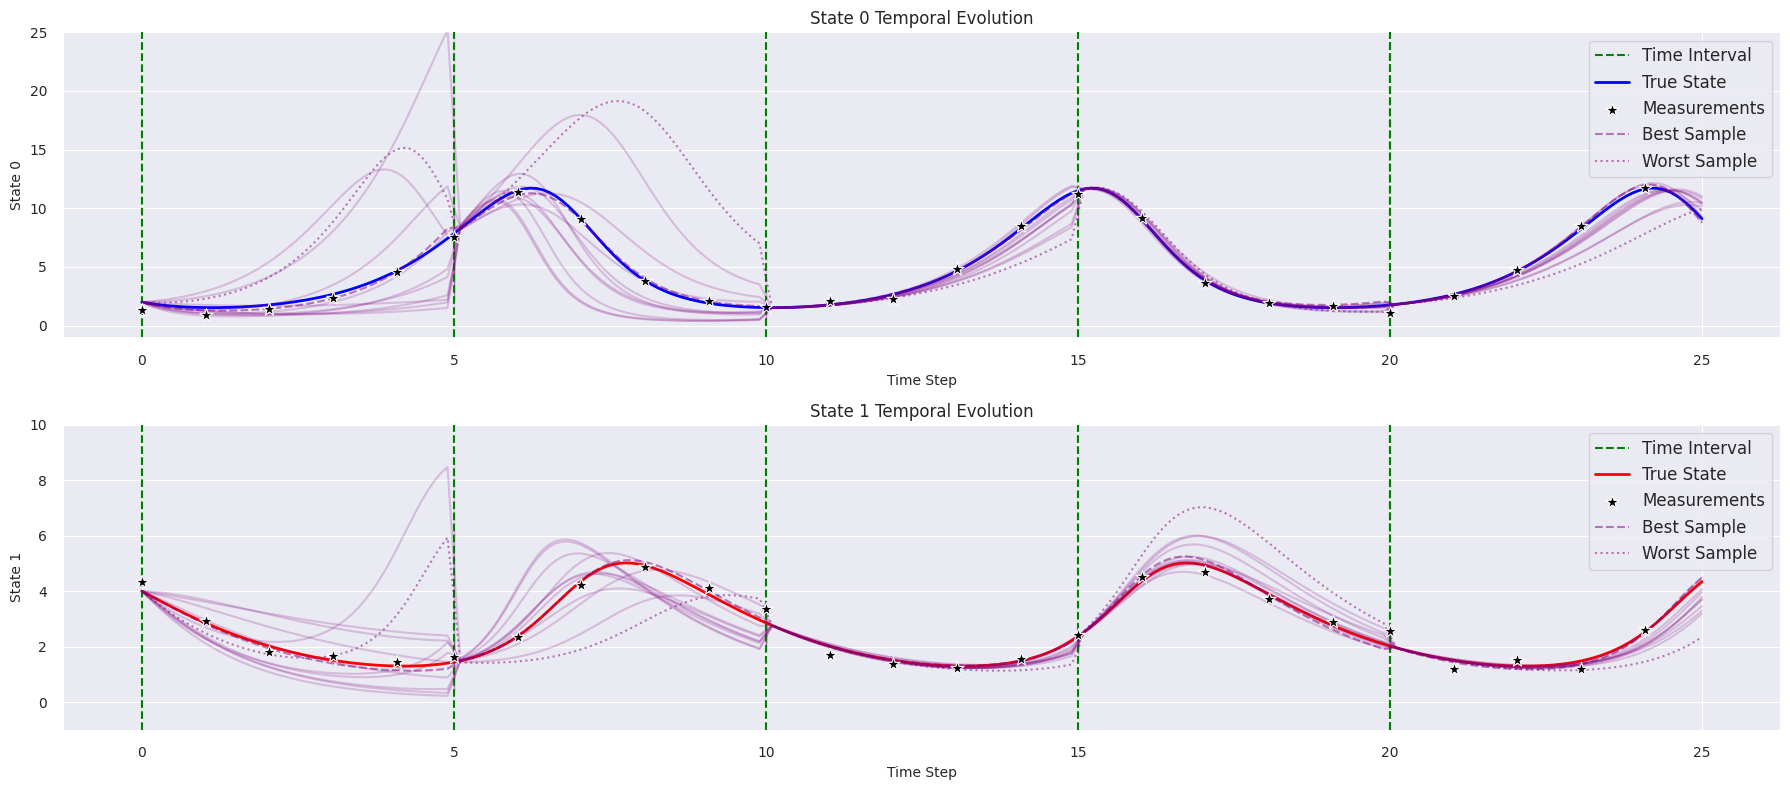

In [71]:
importlib.reload(plt)
plotter = plt.Plotter()

axs = plotter.plot_state_data(lvm, window_type='line')
axs[0].set_ylim([-1, 25])
axs[1].set_ylim([-1, 10])

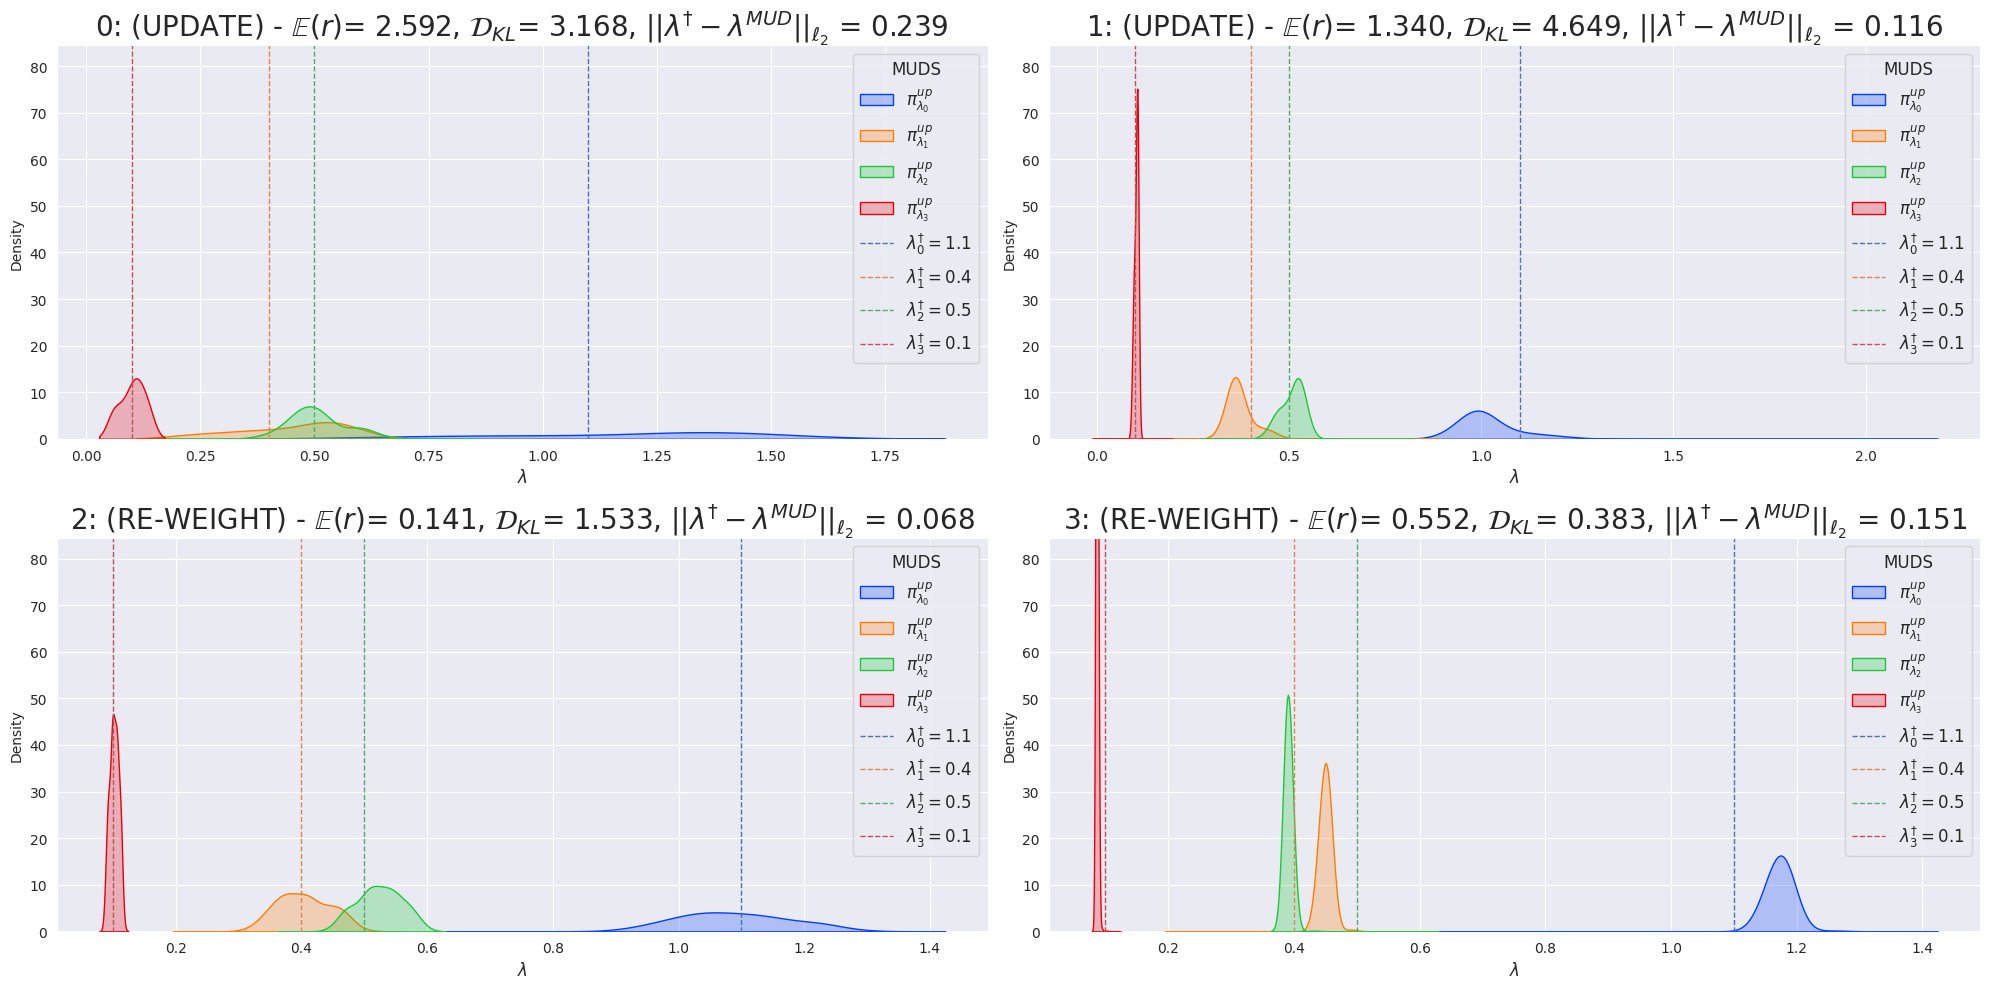

In [72]:
importlib.reload(plt)
plotter = plt.Plotter()

ax = plotter.plot_parameters(lvm, param_idxs=None, nrows=2,ncols=2, plot_initial=False, plot_legend=True)

(-0.1, 0.1)

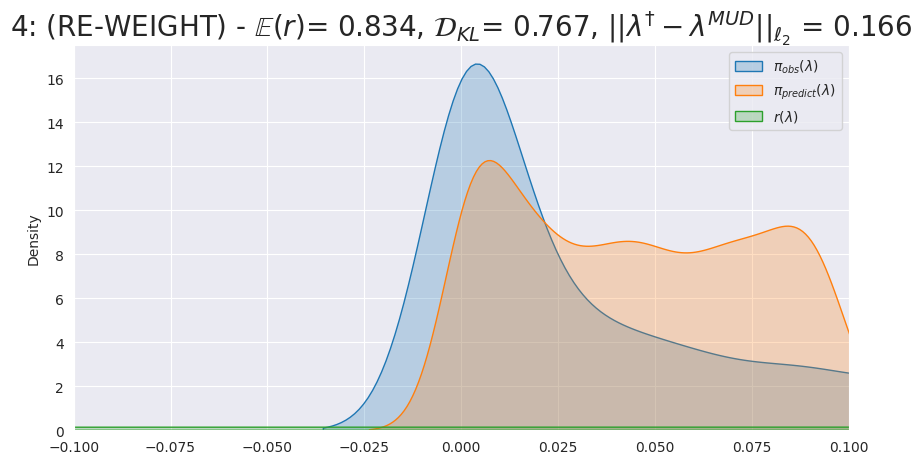

In [9]:
importlib.reload(plt)
plotter = plt.Plotter()

axs = plotter.plot_ratios(lvm, iterations=[4])
axs[0].set_xlim([-0.1,0.1])

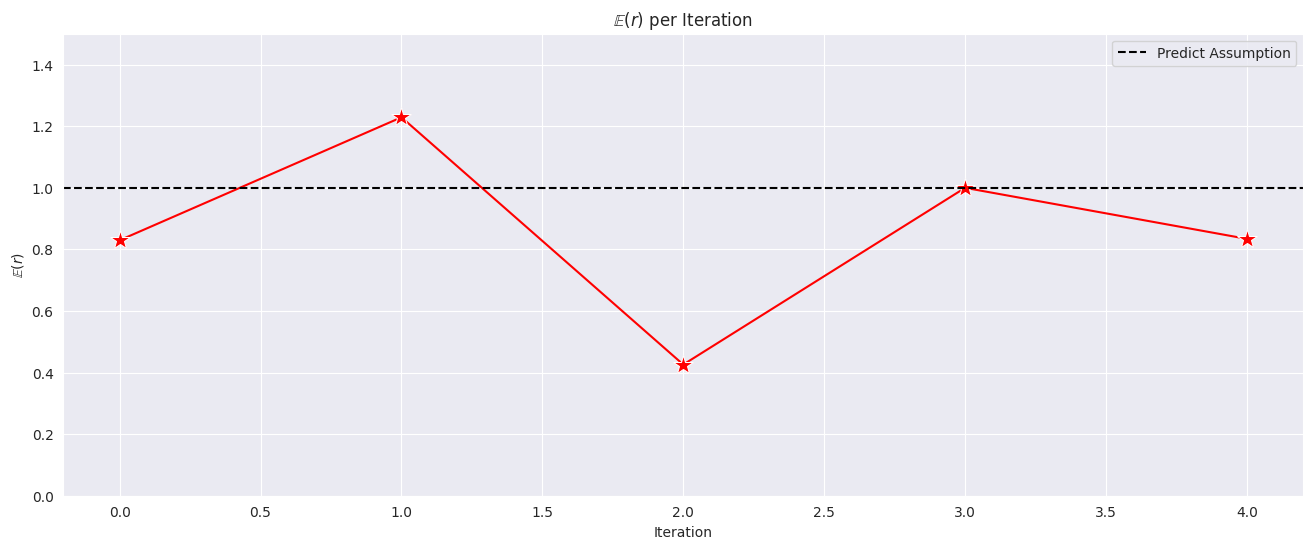

In [10]:
importlib.reload(plt)
plotter = plt.Plotter()

ax = plotter.plot_expected_ratios(lvm)

### Other plots

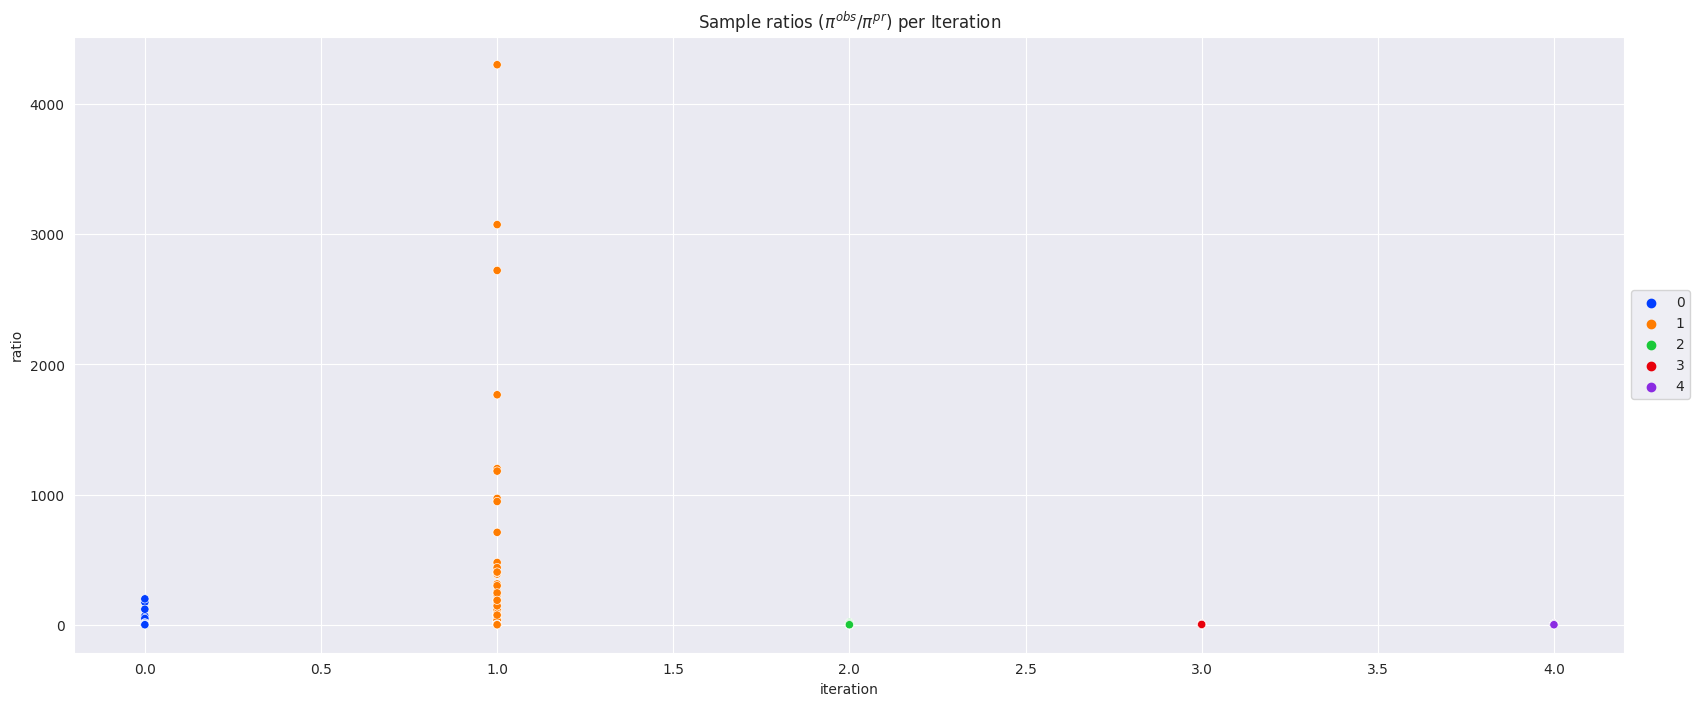

In [33]:
importlib.reload(plt)
plotter = plt.Plotter()

ax = plotter.plot_ratio_scatter(lvm)

<Figure size 1200x1000 with 0 Axes>

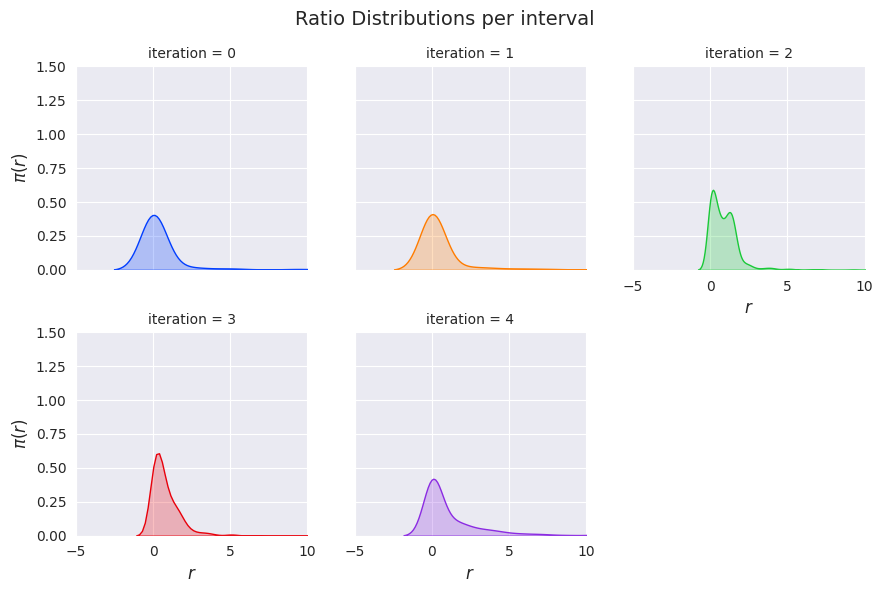

In [17]:
importlib.reload(plt)
plotter = plt.Plotter()
ax = plotter.plot_ratio_dist(lvm, ncols=3)

## Param Shift

In [37]:
num_samples = 1000
lv1_param_mins = [0, 0, 0, 0]
lv1_true_param = lv_p1
x0 = np.array([2, 4])
param_shifts = {50: lv_p2}

search_params = {
    "nc": 1,
    "method": "all",
    "best": "closest",
    "reweight": True,
    "resample": True,
    "min_weight_thresh": 1e-20,
}

SDP.disable_log()
SDP.enable_log('lvm_shift.log') # 'test.log'

lvm_shift = SDP.SequentialDensityProblem(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.3,
    solve_ts=0.1,
    sample_ts=1,
    diff=0.15,
    hot_starts=True,
    param_mins=lv1_param_mins,
    param_shifts=param_shifts,
    search_params=search_params,
)


lvm_shift.seq_solve(
    list(np.arange(5, 100, 5)), num_samples=num_samples, init_seed=lv1_initial_seed
)

In [42]:
lvm_shift.get_full_df('results')

,iteration,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,l2_err,e_r,kl,mean_e_r,e_r_std,min_e_r,max_e_r,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0.0,1.020073,0.415474,0.535008,0.092536,0.088933,1.025684e+00,0.879448,1.025684e+00,NaN,1.025684e+00,1.025684e+00,0.025684,True,True,True,True,UPDATE
0,1.0,1.144041,0.426524,0.568299,0.103627,0.085563,1.060664e+00,1.004057,1.060664e+00,NaN,1.060664e+00,1.060664e+00,0.060664,True,True,True,True,UPDATE
0,2.0,1.041359,0.448388,0.573360,0.107992,0.105951,7.361271e-01,0.690713,7.361271e-01,NaN,7.361271e-01,7.361271e-01,0.263873,True,True,True,True,RE-WEIGHT
0,3.0,1.045578,0.381962,0.573023,0.103311,0.092900,9.217223e-01,1.258334,9.217223e-01,NaN,9.217223e-01,9.217223e-01,0.078278,True,True,True,True,RE-WEIGHT
0,4.0,1.118205,0.423153,0.457905,0.089288,0.052481,8.982552e-01,1.338004,8.982552e-01,NaN,8.982552e-01,8.982552e-01,0.101745,True,True,True,True,UPDATE
0,5.0,1.100234,0.402581,0.439593,0.087543,0.061733,9.888614e-01,1.089782,9.888614e-01,NaN,9.888614e-01,9.888614e-01,0.011139,True,True,True,True,RE-WEIGHT
0,6.0,1.142777,0.412111,0.455019,0.093134,0.063616,9.438657e-01,0.471831,9.438657e-01,NaN,9.438657e-01,9.438657e-01,0.056134,True,True,True,True,RE-WEIGHT
0,7.0,1.188606,0.454313,0.495869,0.098151,0.104026,1.025857e+00,0.212427,1.025857e+00,NaN,1.025857e+00,1.025857e+00,0.025857,True,True,True,True,RE-WEIGHT
0,8.0,1.044713,0.377847,0.492449,0.093684,0.060368,9.817774e-01,0.686800,9.817774e-01,NaN,9.817774e-01,9.817774e-01,0.018223,True,True,True,True,RE-WEIGHT
0,9.0,1.071921,0.385399,0.515438,0.104118,0.035453,9.950495e-01,0.229483,9.950495e-01,NaN,9.950495e-01,9.950495e-01,0.004951,True,True,True,True,RE-WEIGHT


(-1.0, 10.0)

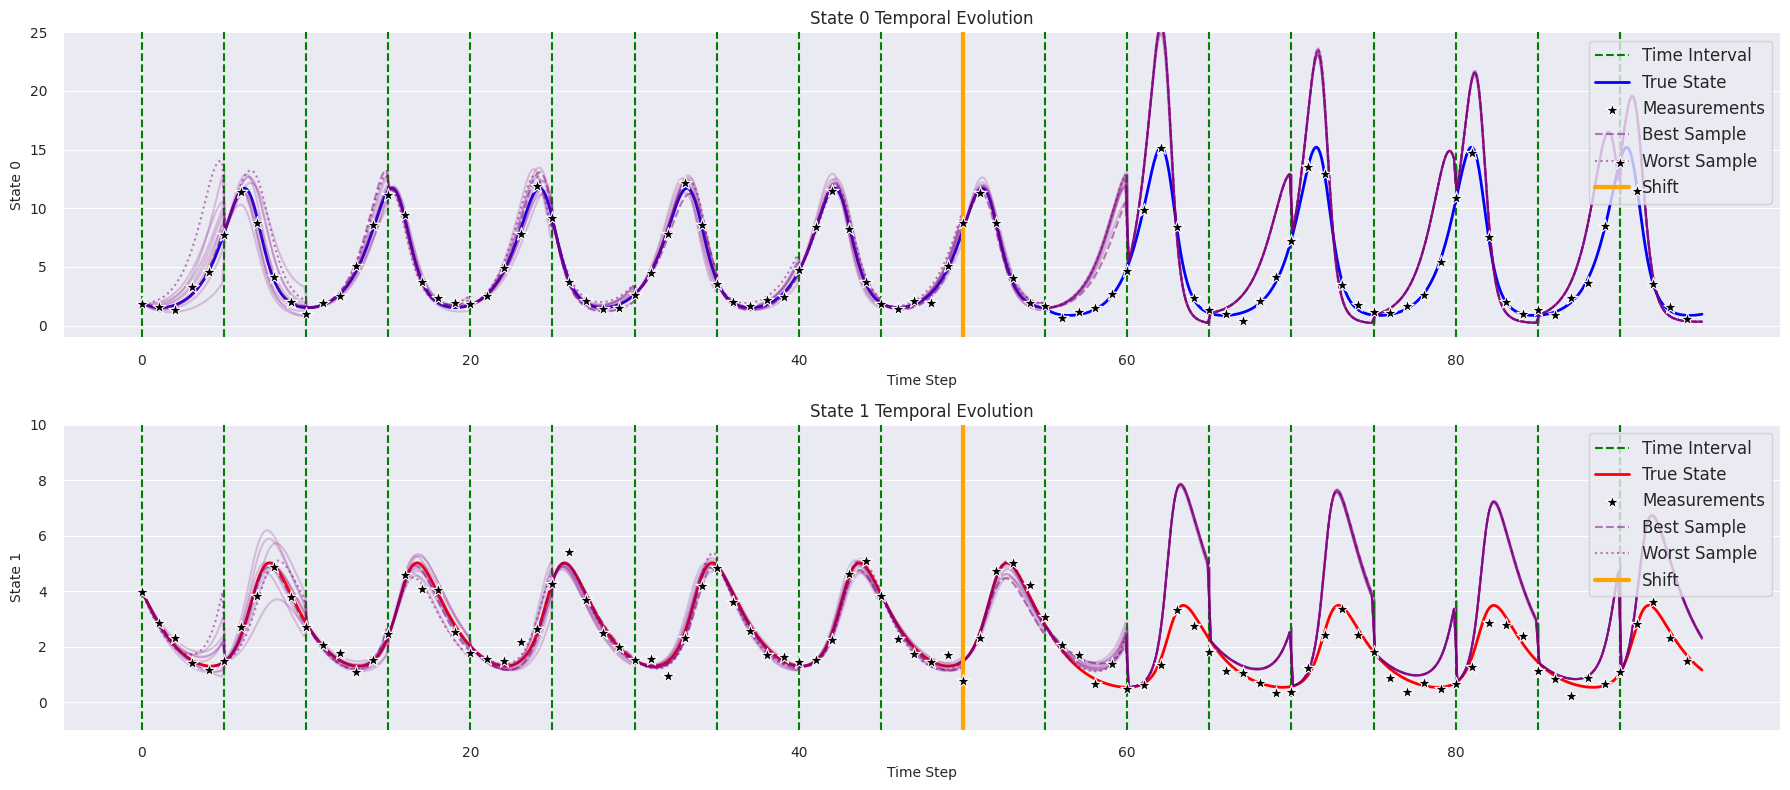

In [36]:
axs = plotter.plot_state_data(lvm_shift, window_type='line')
axs[0].set_ylim([-1, 25])
axs[1].set_ylim([-1, 10])

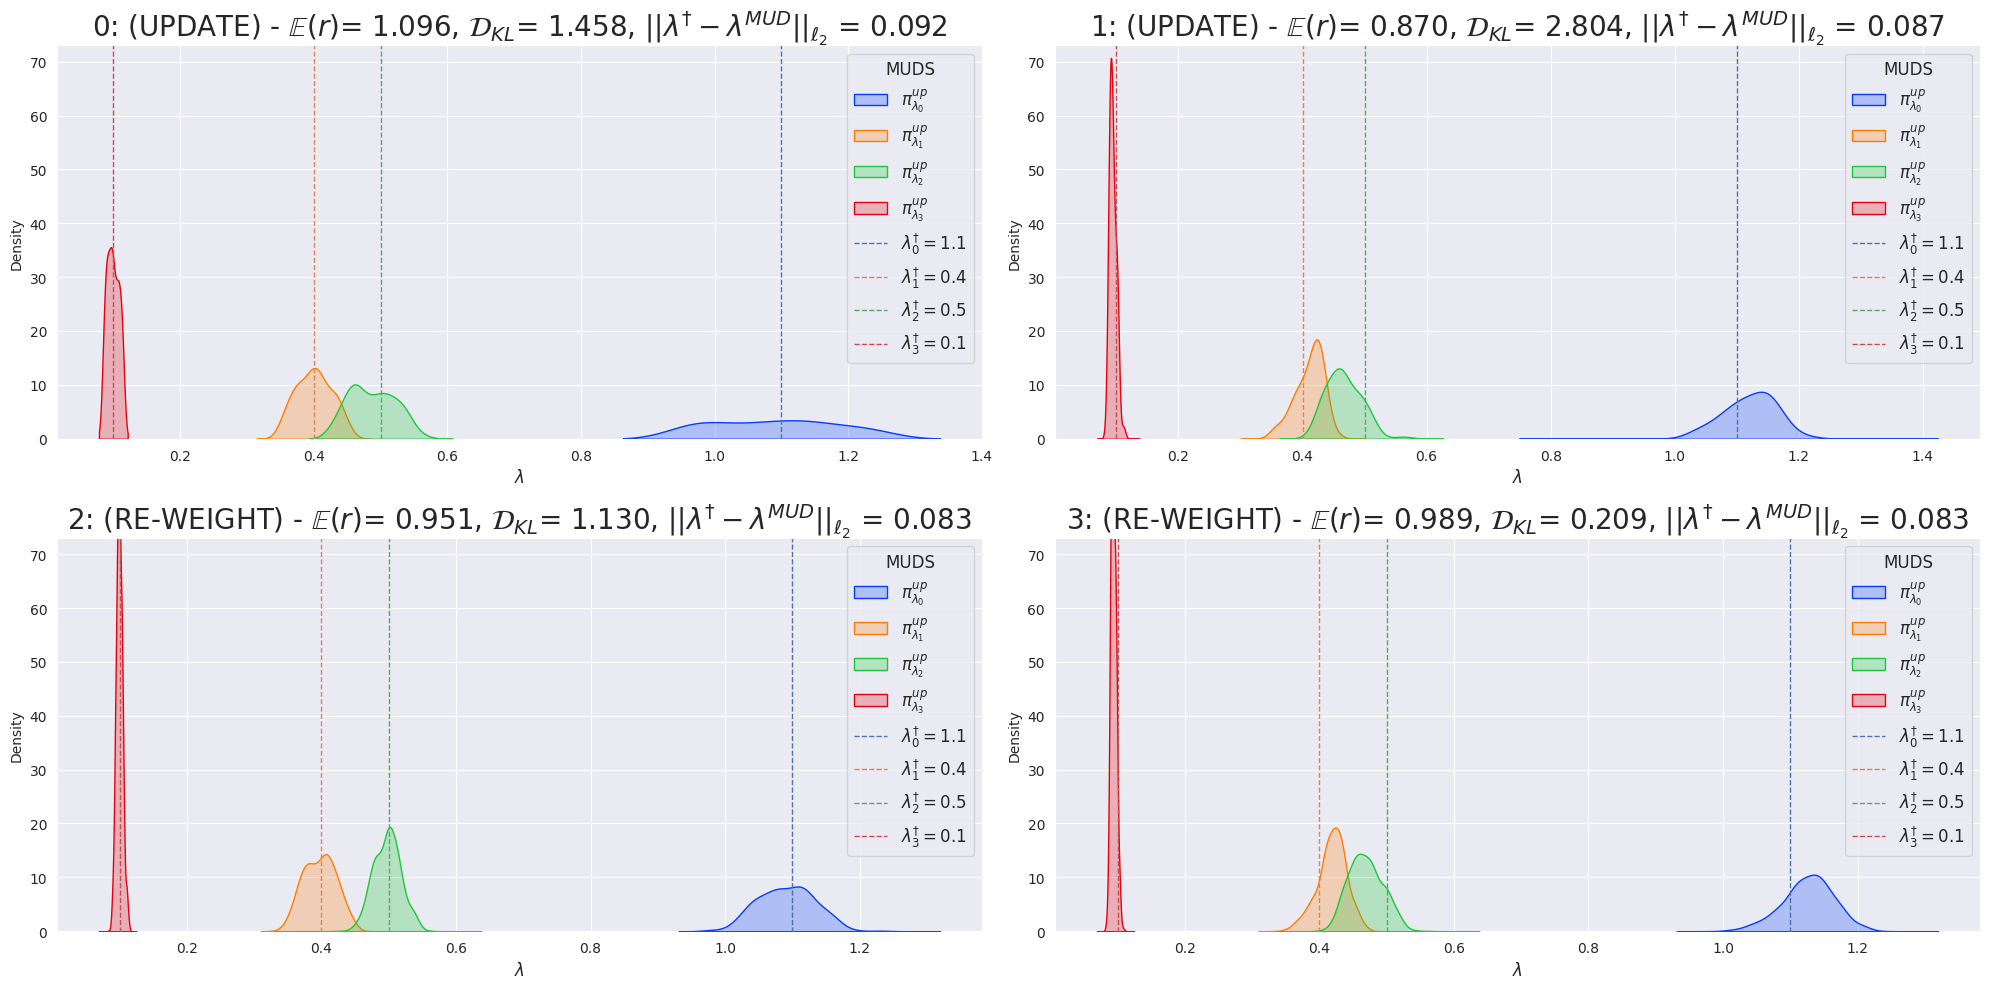

In [24]:
importlib.reload(plt)
plotter = plt.Plotter()

ax = plotter.plot_parameters(lvm, param_idxs=None, nrows=2, ncols=2, plot_initial=False, plot_legend=True)

## Param Shift - Detecting

Ways to detect:

1. exp_r shift -> Shift in value of E_r
2. KL divergence large 

In [83]:
num_samples = 1000
lv1_param_mins = [0, 0, 0, 0]
lv1_true_param = lv_p1
x0 = np.array([2, 4])
param_shifts = {50: lv_p2}

search_params = {
    "nc": 1,
    "method": "all",
    "best": "closest",
    "reweight": True,
    "resample": True,
    "min_weight_thresh": 1e-20,
    "mean_exp_delta_thresh": 0.5,
    "kl_thresh_Factor": 3.0,
    "exp_thresh": 0.5,
}

importlib.reload(SDP)
SDP.disable_log()
SDP.enable_log('lvm_shift.log') # 'test.log'

lvm_shift = SDP.SequentialDensityProblem(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.1,
    solve_ts=0.1,
    sample_ts=1,
    diff=0.5,
    hot_starts=True,
    param_mins=lv1_param_mins,
    param_shifts=param_shifts,
    search_params=search_params,
)


lvm_shift.seq_solve(
    list(np.arange(5, 120, 5)), num_samples=num_samples, init_seed=lv1_initial_seed
)

on 52: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
         warnings.warn(warning_msg, ODEintWarning)


on 631: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
          warnings.warn(warning_msg, ODEintWarning)


In [84]:
lvm_shift.get_full_df('results')

,iteration,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,l2_err,e_r,kl,mean_e_r,e_r_std,min_e_r,max_e_r,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,0.0,1.384078,0.485643,0.387418,0.083952,0.317753,9.718998e-01,2.830717,9.718998e-01,NaN,9.718998e-01,9.718998e-01,0.028100,True,True,True,True,UPDATE
0,1.0,1.187574,0.425297,0.513922,0.100043,0.092211,1.076408e+00,3.243049,1.076408e+00,NaN,1.076408e+00,1.076408e+00,0.076408,True,True,True,True,UPDATE
0,2.0,1.064808,0.348357,0.427385,0.089904,0.096335,1.061296e+00,2.847409,1.061296e+00,NaN,1.061296e+00,1.061296e+00,0.061296,True,True,True,True,UPDATE
0,3.0,1.220801,0.453040,0.411505,0.086288,0.159454,1.071156e+00,2.129300,1.071156e+00,NaN,1.071156e+00,1.071156e+00,0.071156,True,True,True,True,UPDATE
0,4.0,1.111141,0.411170,0.499027,0.102790,0.016051,1.083718e+00,1.686706,1.083718e+00,NaN,1.083718e+00,1.083718e+00,0.083718,True,True,True,True,UPDATE
0,5.0,1.074170,0.396158,0.500601,0.098747,0.026152,1.021412e+00,0.695146,1.021412e+00,NaN,1.021412e+00,1.021412e+00,0.021412,True,True,True,True,UPDATE
0,6.0,1.090121,0.393317,0.509764,0.103155,0.015733,9.712326e-01,1.644778,9.712326e-01,NaN,9.712326e-01,9.712326e-01,0.028767,True,True,True,True,UPDATE
0,7.0,1.089473,0.400166,0.511715,0.104908,0.016497,1.025275e+00,0.137782,1.025275e+00,NaN,1.025275e+00,1.025275e+00,0.025275,True,True,True,True,RE-WEIGHT
0,8.0,1.132863,0.425218,0.504770,0.099670,0.041699,1.027293e+00,0.685251,1.027293e+00,NaN,1.027293e+00,1.027293e+00,0.027293,True,True,True,True,RE-WEIGHT
0,9.0,1.112713,0.405622,0.491149,0.098932,0.016514,1.017741e+00,0.274498,1.017741e+00,NaN,1.017741e+00,1.017741e+00,0.017741,True,True,True,True,RE-WEIGHT


In [85]:
lvm_shift.domain, lvm_shift.true_param, lvm_shift.param_shifts

(array([[0.55, 1.65],
        [0.2 , 0.6 ],
        [0.25, 0.75],
        [0.05, 0.15]]),
 [1.1, 0.4, 0.5, 0.1],
 {50: [1.1, 0.55, 0.5, 0.1]})

(-1.0, 10.0)

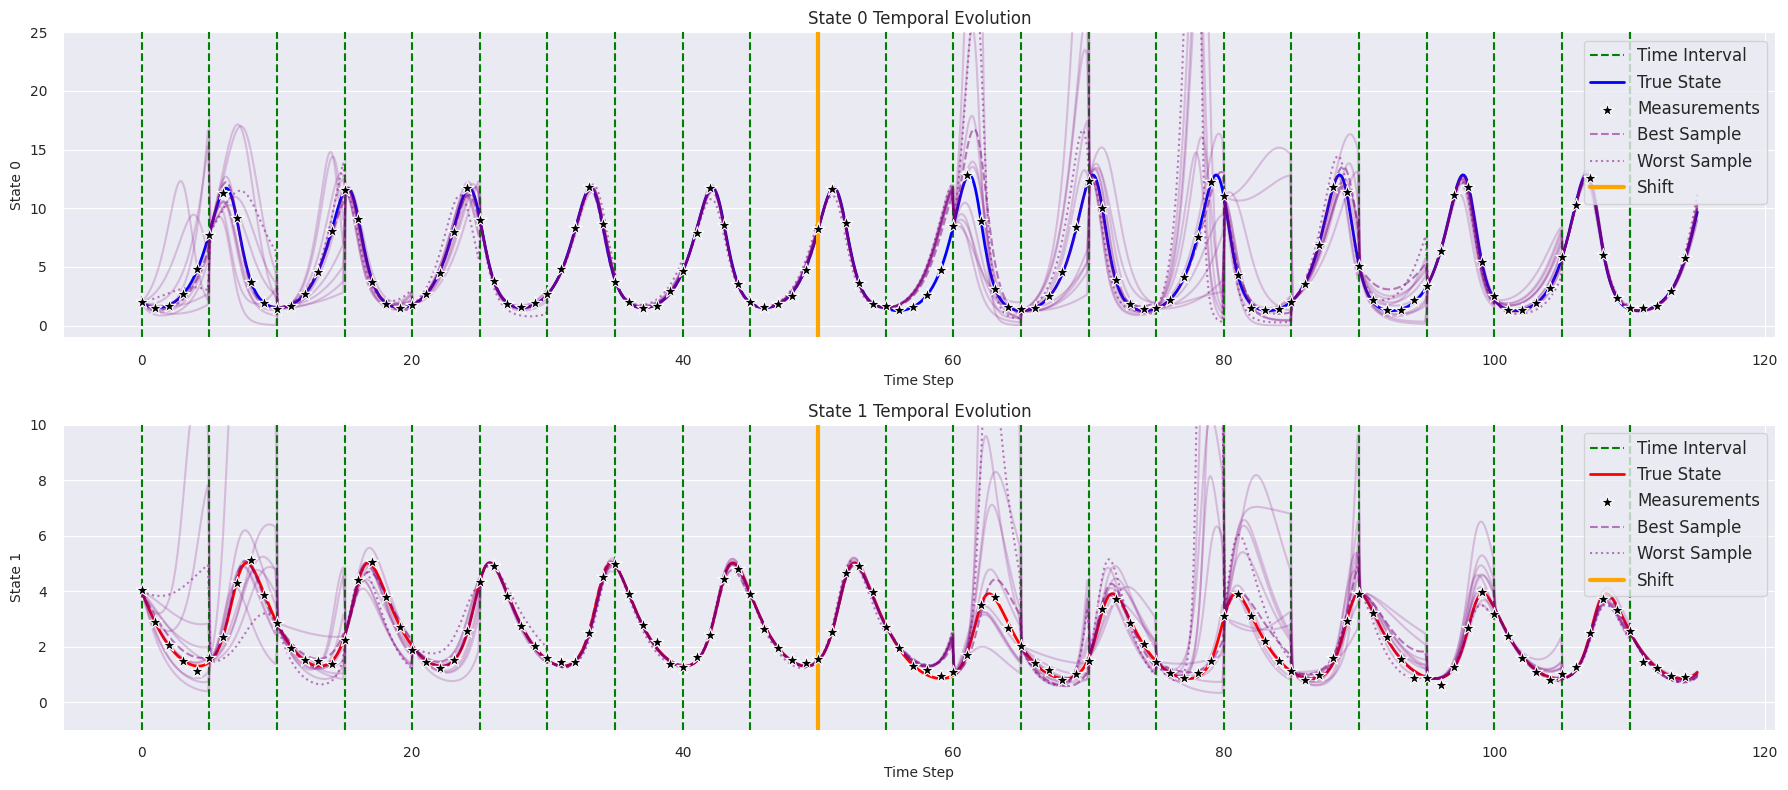

In [86]:
axs = plotter.plot_state_data(lvm_shift, window_type='line')
axs[0].set_ylim([-1, 25])
axs[1].set_ylim([-1, 10])

In [36]:
x0 = lvm_shift._get_df(lvm_shift.dfs['state'][11], 'true_vals', typ='state')[-1]
x0

array([4.94960516, 0.53119671])

In [38]:
num_samples = 1000
lv1_param_mins = [0, 0, 0, 0]
# lv1_true_param = lv_p1
# x0 = np.array([2, 4])
param_shifts = None # {50: lv_p2}

search_params = {
    "nc": 1,
    "method": "all",
    "best": "closest",
    "reweight": True,
    "resample": True,
    "min_weight_thresh": 1e-20,
    "mean_exp_delta_thresh": 0.5,
    "kl_thresh_Factor": 3.0,
    "exp_thresh": 0.5,
}

importlib.reload(SDP)
SDP.disable_log()
SDP.enable_log('lvm_shift.log') # 'test.log'

lvm_shift = SDP.SequentialDensityProblem(
    run_lv,
    x0,
    lv_p2,
    measurement_noise=0.1,
    solve_ts=0.1,
    sample_ts=1,
    diff=0.15,
    hot_starts=True,
    param_mins=lv1_param_mins,
    param_shifts=param_shifts,
    search_params=search_params,
)


lvm_shift.seq_solve(
    list(np.arange(5, 120, 5)), num_samples=num_samples, init_seed=lv1_initial_seed
)

(-1.0, 10.0)

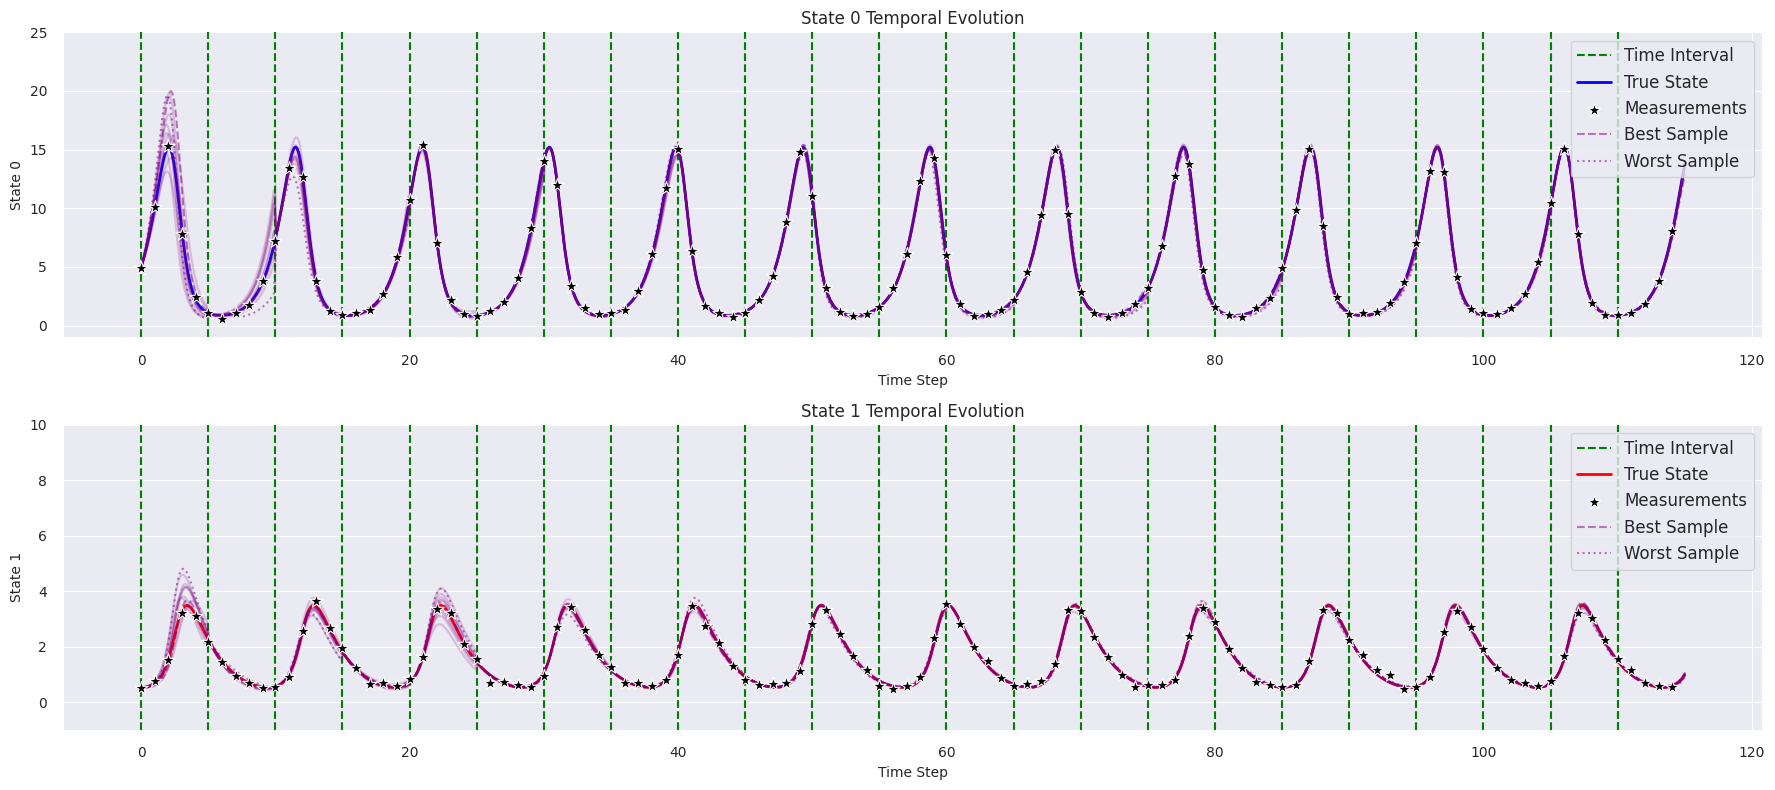

In [39]:
axs = plotter.plot_state_data(lvm_shift, window_type='line')
axs[0].set_ylim([-1, 25])
axs[1].set_ylim([-1, 10])